# Описание проекта.

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.101.506310.JPG" width="110" align="left"/> Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. <br>Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. <br>В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».<br clear="left"/>

# Настройка проекта.

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.10.53546.JPG" width="110" align="left"/> Этот раздел предназначен для настройки окружения и импорта необходимых библиотек для работы с проектом. В этом разделе мы установим и настроим все необходимые программы и пакеты, которые будут использоваться в проекте, а также загрузим библиотеки, необходимые для обработки данных и построения моделей. Затем мы настроим нашу среду разработки и загрузим все необходимые файлы и датасеты. <br>В дополнение к этому, мы создадим несколько функций, которые будут использоваться в проекте для обработки и визуализации данных. Мы также опишем, как эти функции будут использоваться в проекте и какие параметры они принимают.<br clear="left"/>

## Импорт необходимых для исследования библиотек.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import os
import csv
import io
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy import stats as st
from IPython.display import HTML
from scipy.stats import levene
from matplotlib.colors import ListedColormap

## Используемые кастомные функции и глобальные переменные.

In [2]:
# The relevant period for forecasting sales for the next year.
actual_period_start_year = 0

# Custom function to add captions to barplots. Stolen from Internet
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            # add captions to the vertical barplot
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            # add captions to the horizontal barplot
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")
                
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# --------------------------------------------------------------------

# Custom function for Sturges rule
'''
Yes, I know it's not exactly Sturges rule.
But the Sturges rule is a rule of thumb and empirically in this study such a logarithm is better.
So I call this function 'my_sturges'.
'''
def my_sturges(n=1000):
    return 1 + int(3.322*np.log(n))
#   return 1 + int(3.322*np.log10(n))

# --------------------------------------------------------------------

# Custom function to nan displaying nicely
def my_nan_disp(df=pd.DataFrame(), size=(5, 3)):
    _nan = pd.Series(round(df.isna().mean()*100,))

    _ax_nan = sns.barplot(x=_nan, \
                          y=_nan.index, \
                          color='DodgerBlue')

    show_values(_ax_nan, orient="h")

    _ax_nan.set(xlabel='Количество пропусков, %', \
                ylabel='Столбец в DataFrame', \
                title='% пропусков в столбцах', \
                xlim=(0, 100))

    _ax_nan.figure.set_size_inches(5, 3)
    _ax_nan.grid(axis='x', linestyle='-')

    plt.show(_ax_nan)

# --------------------------------------------------------------------

# Custom function for sales distribution
def my_plat_dist(df=pd.DataFrame(), plat='', xl=(0, 0), yl=(0, 0)):
    _p = df[df['platform'] == plat]

    _piv = _p.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').reset_index()

    _x = _piv['year_of_release']
    _y = _piv['total_sales']

    _f = interp1d(_x, _y, kind='quadratic')

    _x_new = np.linspace(_x.min(), _x.max(), 100)
    _y_new = _f(_x_new)

    plt.plot(_x_new, _y_new, '-', label=plat)

    plt.xlim(xl)
    plt.ylim(yl)

    plt.legend()

    plt.xlabel('Год')
    plt.ylabel('Продажи')
    plt.title('Распределение продаж', y=1.05)

# --------------------------------------------------------------------

# Custom function for displaying user persona parameters    
def my_user_persona(df, reg_sales, per, xr='0', ax=None):
    df.sort_values(reg_sales, ascending=False).\
       iloc[0:21][per].\
       hist(xrot=xr, \
       color='DodgerBlue', \
       ax=ax, \
       bins=my_sturges(len(df[per])))
    if ax !=None:
        ax.set_title(per)
        ax.set_xlabel('Признак')
        ax.set_ylabel('Частота значений признака')
        
# --------------------------------------------------------------------

# Custom function for displaying user persona parameters v.2   
def my_user_persona_new(df=pd.DataFrame(), reg_sales='', per='', ax=None):
    _user_pivot = df.pivot_table(index=per, values=reg_sales, aggfunc='sum').\
                     reset_index()
    _user_pivot.reset_index(drop=True, inplace=True)

    # Defining the threshold percentage value
    _threshold_pct = 5

    # Grouping the data with values less than the threshold and replacing them with "Other"
    _user_pivot.loc[(_user_pivot[reg_sales] / _user_pivot[reg_sales].sum()) * 100 < _threshold_pct, per] = 'Other'
    _user_pivot = _user_pivot.groupby(per).sum()

    # Sorting the data in descending order by the values
    _user_pivot = _user_pivot.sort_values(by=reg_sales, ascending=False)

    # Creating a pie chart
    ax.pie(_user_pivot[reg_sales], \
           labels=_user_pivot.index, \
           autopct='%1.1f%%', \
           startangle=45, \
#           colors=plt.cm.Blues(np.linspace(0.3, 1, 8)), \
           colors=plt.cm.cividis(np.linspace(0.3, 1, 8)), \
           textprops={'fontsize': 8})

    # Dictionary defining the region by the sales type name
    _reg_dict = {'na_sales': 'Северная Америка', \
                 'other_sales': 'Остальной мир', \
                 'eu_sales': 'Европа', \
                 'jp_sales': 'Япония'}

    # Dictionary defining the classifier
    _clas_dict = {'genre': 'Деление по жанрам', \
                  'platform': 'Деление по платформам', \
                  'rating': 'Деление по рейтингу'}

    # Customizing the appearance
    ax.axis('equal')  # Set equal scaling for the x and y axes
#    ax.set_title(_reg_dict.get(reg_sales)+_clas_dict.get(per))
    ax.set_title(_clas_dict.get(per))
        
# --------------------------------------------------------------------

# Custom function for displaying the relationship between game rating and game sales across platforms
def my_sales_dist_by_score_by_plt(nrows=2, \
                                  ncol=3, \
                                  figsize=(11, 5), \
                                  score='user', \
                                  plat=pd.Series(dtype='object'), \
                                  data=pd.DataFrame()):
    
    _fig, _ax = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)

    _suptitle = {'user': 'Распределение продаж в зависимости от отзыва пользователей по платформам', \
                 'critic': 'Распределение продаж в зависимости от отзыва критиков по платформам'}
    _score_col = {'user': 'user_score', \
                  'critic': 'critic_score'}
    _x_label = {'user': 'Отзыв пользователей', \
                'critic': 'Отзыв критиков'}
    _x_lim = {'user': 10, \
              'critic': 100}
    
    plt.suptitle(_suptitle.get(score, _suptitle.get('user')), y=1.05)

    _k = 0
    for i in range(nrows):
        for j in range(ncol):
            _games_p = data[data['platform'] == plat[_k]]
            _games_p.plot(x=_score_col.get(score, _score_col.get('user')), \
                          y='total_sales', \
                          kind='scatter', \
                          alpha=0.7, \
                          color='DodgerBlue', \
                          ax=_ax[i, j])
            _plat_title = 'Платформа ' + plat[_k]
            _ax[i, j].set_title(_plat_title, y=1.05, fontdict={'fontsize': 11})
            _ax[i, j].set_xlabel(_x_label.get(score, _x_label.get('user')))
            _ax[i, j].set_ylabel('Общие продажи')
            _ax[i, j].set_xlim(0, _x_lim.get(score, _x_lim.get('user')))
            _ax[i, j].set_ylim(0)
            _ax[i, j].tick_params(axis='x', labelrotation=0)
            _k += 1

    plt.subplots_adjust(wspace=0.5, hspace=1)
    plt.show()

## Загрузка данных.

Безопасная загрузка данных из одного из возможных источников с обработкой exceptions. <br>Сепаратор определяется автоматически. <br>Забегая вперёд, загрузим данные сэкономив около 740 KB оперативной памяти на использовании типа `'float16'` вместо `'float64'`.

In [3]:
# Dictionary that maps different locations to file paths or URLs
filename_dict = {'local': 'games.csv', \
                 'practicum': '/datasets/games.csv', \
                 'ya': 'https://code.s3.yandex.net/datasets/games.csv'}

# Check if file exists in local file system
if os.path.isfile(filename_dict.get('local')):
    print('File exists locally')
    loc = 'local'
# Check if file exists on Practicum platform
elif os.path.isfile(filename_dict.get('practicum')):
    print('File exists on Practicum')
    loc = 'practicum'
# Check if file exists on Yandex server
elif requests.head(filename_dict.get('ya')).status_code == 200:
    print('File exists on Yandex server')
    loc = 'ya'
# Raise error if file not found in any location
else:
    raise RuntimeError('Something went wrong while finding the file.')
    
# Get filename based on location
filename = filename_dict.get(loc)
print(f'Filename: \'{filename}\'')

# Determine delimiter used in CSV file
if loc != 'ya':
    try:
        # Open file and read first 1024 bytes to determine delimiter
        with open(filename, 'r', encoding='utf-8') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
            print(f'Delimiter in file: \'{dialect.delimiter}\'')
    except Exception:
        raise RuntimeError('Something went wrong while opening the local|practicum file for delimiter analysis')
else:
    try:
        # Download file content and read first 1024 bytes to determine delimiter
        dialect = csv.Sniffer().sniff(io.StringIO(requests.get(filename).text).read(1024))
        print(f'Delimiter in file: \'{dialect.delimiter}\'')
    except Exception:
        raise RuntimeError('Something went wrong while opening the url file for delimiter analysis')

# Read CSV file into pandas DataFrame
try:
    games = pd.read_csv(filename, \
                        sep=dialect.delimiter, \
                        dtype={'Year_of_Release': np.float16, \
                               'NA_sales': np.float16, \
                               'EU_sales': np.float16, \
                               'JP_sales': np.float16, \
                               'Other_sales': np.float16, \
                               'Critic_Score': np.float16})
    print(f'Data loaded from \'{loc}\'.')
except Exception:
    raise RuntimeError('Something went wrong while opening the file as a CSV')

File exists locally
Filename: 'games.csv'
Delimiter in file: ','
Data loaded from 'local'.


## Оптимизация отображения.

Снимем ограничения вывода на экран и оставляем привычные два знака после запятой.

In [4]:
# Display options for pandas DataFrame objects
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.2f}'.format

# plt.style.available
plt.style.use('seaborn-colorblind')

# Create Cividis color palette
cividis = ListedColormap(["#00204C", "#002F67", "#003C81", "#004A9B", "#0A5FB2", \
                          "#1B6CBB", "#3077B6", "#4980AB", "#637388", "#7B7E6B", \
                          "#948E4F", "#AD9E35", "#C8AD20", "#E2BB1B", "#F8C41B"])

# Общая информация о данных.

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.8.41038.JPG" width="110" align="left"/> Общая информация о данных (Data overview) - это начальный этап анализа данных в Data Science, который включает в себя получение общей информации о наборе данных. Этот этап важен, чтобы понять, какие данные содержатся в наборе данных, какие проблемы могут быть связаны с этими данными, а также какие варианты анализа исследовател может применять к данным. <br>Получение общей информации о данных помогает определить, какие методы и технологии могут быть применены для анализа данных, а также какие проблемы могут возникнуть в процессе анализа. Это позволяет исследователю принимать информированные решения в процессе работы с данными.<br clear="left"/>

## Описание данных.

Описание данных.<br>
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
<br>

Данные за 2016 год могут быть неполными.


## Метод head().

In [5]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.38,28.95,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Названия столбцов нужно привести к нижнему регистру.

## Метод info().

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float16
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float16
 5   EU_sales         16715 non-null  float16
 6   JP_sales         16715 non-null  float16
 7   Other_sales      16715 non-null  float16
 8   Critic_Score     8137 non-null   float16
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float16(6), object(5)
memory usage: 848.9+ KB


Метод показывает наличие пропусков, а также несоответствие типов в `year_of_release` и `user_score`.

## Пропуски.

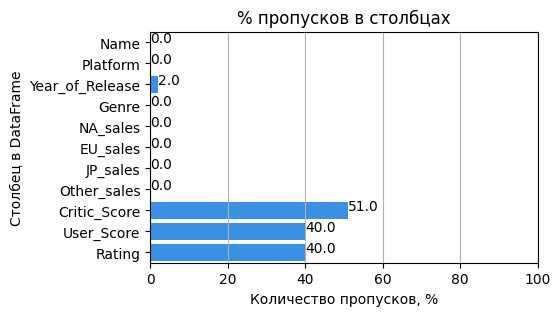

In [7]:
my_nan_disp(games)

А вот и, собственно, как распределяются пропуски по данным.

## Метод duplicated().

Также убедимся в отсутствии явных дубликатов.

In [8]:
games.duplicated().sum()

0

In [9]:
games.loc[games.duplicated(subset=['Name', 'Platform', 'Year_of_Release'], keep=False)]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
604,Madden NFL 13,PS3,"2,012.00",Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,"1,993.00",NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,"2,012.00",Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


А вот неявные дубликаты есть.

## Метод corr().

И посмотрим насколько данные коррелируют между собой.

In [10]:
games.corr().style.format('{:.2f}').background_gradient('Blues')

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
Year_of_Release,1.00,-0.09,0.00,-0.17,0.04,0.01
NA_sales,-0.09,1.00,0.77,0.45,0.64,0.24
EU_sales,0.00,0.77,1.00,0.44,0.72,0.22
JP_sales,-0.17,0.45,0.44,1.00,0.29,0.15
Other_sales,0.04,0.64,0.72,0.29,1.00,0.20
Critic_Score,0.01,0.24,0.22,0.15,0.20,1.00


Корреляции о которых можно говорить наблюдаются только в парах `'na_sales' - 'eu_sales'` и `'other_sales' - 'eu_sales'`.

## Entertainment Software Rating Board.

Собственно, что говорит <a href="https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board">Википедия</a> об этой организации и её рейтинге:

«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры.

«E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально "K-A" ("Kids to Adults").

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года.

«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

«M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.

«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое.

«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

«RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»: Продукт отправлен ESRB на оценку, но примерное содержание близко к рейтингу «M». Данная маркировка была введена с 2021 г. и распространяется на демо или презентационный вариант.

Но тут нам важно другое. Никакого "tbd" рейтинга тут нет и в помине. "tbd" — это, некоторым образом, чья-то самодеятельность. Запомним это.

## Краткий вывод.

После общего ознакомления с имеющимися данными, можно сделать следующие выводы:
- Названия столбцов не соответствуют стандартному формату. Также заметно несоответствие типов данных в столбцах `Year_of_Release` и `User_Score`.
- Имеются пропуски данных в столбцах `Name`, `Genre`, `Year_of_Release`, `Critic_Score`, `User_Score` и `Rating`, а также обнаружены ошибки в типах данных в столбцах `Year_of_Release` и `User_Score`.
- В данных не обнаружено явных дубликатов.
- Высокие корреляции в данных наблюдаются только между парами `NA_sales-EU_sales` и `Other_sales-EU_sales`.
- Рейтинговый состав Entertainment Software Rating Board не включает тип рейтинга `tbd`.

# Предобработка данных.

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.101.507074.JPG" width="110" align="left"/> Предобработка данных (Data preprocessing) - это процесс подготовки данных для анализа и обработки в целом. Она является важной частью анализа данных, поскольку качество и точность анализа зависят от качества данных.
<br>Цель предобработки данных - устранение ошибок и шума в данных, а также подготовка данных для дальнейшего анализа. Хорошо выполненная предобработка данных может повысить точность и эффективность анализа, уменьшить ошибки в моделях машинного обучения и повысить достоверность результатов.<br clear="left"/>

## Приведение к нижнему регистру.

Следуя Pythonic стилистике названия столбцов нам нужно привести к нижнему регистру.

In [11]:
games.columns = games.columns.str.lower()

## Удаление неявных дубликатов.

In [12]:
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first')

## Обработка пропусков рейтинга Entertainment Software Rating Board.

Цитаты. Процесс присвоения рейтинга. Для определения рейтинга издатель присылает в ESRB видеоролик, который содержит наиболее впечатляющие и резкие сцены игры. Также издатель заполняет специальную анкету сведениями о содержании игры.

На веб-сайте ESRB сообщается, что затем рецензенты независимо оценивают продукт и определяют рейтинг. Оценкой рейтинга занимаются многие люди разных возрастов и слоёв общества. Это могут быть бывшие школьные учителя, родители, профессионалы и различные работники из других сфер деятельности, не связанные с игровой индустрией. Если рецензенты сходятся в оценке, то к рейтингу добавляют краткие описания и ESRB уведомляет издателя о своём решении.

Когда игра готова к продаже, издатель отправляет копии финальной версии в ESRB. Подвергается осмотру упаковка игры, а предоставленные издателем сведения о содержании игры обычно проверяются путём её тестирования. Если игра оказывается более жёсткой, чем было представлено в видеоролике, или покупатели высказываются о несоответствии рейтинга и содержимого продукта, к издателю могут быть применены различные санкции.

Будем считать, что отсутствие рейтинга ESRB на игре означает, что игра была выпущена за пределами США и Канады, где ESRB не действует. Заполним пропуски соответствующей этому факту константой.

## Обработка пропусков в столбцах `name` и `genre`.

Посмотрим на эти пропуски:

In [13]:
games['rating'] = games['rating'].fillna('NON_NA_GAME')

In [14]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,NaN,NaN,NON_NA_GAME


In [15]:
games[games['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,NaN,NaN,NON_NA_GAME


Это одна и таже строчка, не содержащая важной информации. Удалим её.

In [16]:
games = games.dropna(subset=['name'])

## Что делать с `'tbd'`?

Как, например, мы уже выяснили, такого рейтинга как `'tbd'` в Entertainment Software Rating Board не существует. Вполне возможно, что `'tbd'` сюда попал как вольная замена "RP" ("Rating Pending"), а может быть и ещё каким-то образом, некоторые рейтинги определяются годами и скорее всего компания просто забыла про свои благие намерения. Вполне очевидно, что заменить значения `'tbd'` на численные без дополнительных данных каким-либо разумным образом не получится ввиду собственно природы формирования рейтинговых оценок. Мы должны избежать искажения исходных данных при условии их приведения к удобной для обработки форме. В данном случае мы произведём замену значений `'tbd'` на `'nan'`.

In [17]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan

## Обработка столбца `'year_of_release'`.

Заполняем пропуски в годах. В отличии от истории с `'tbd'` здесь нам повезло больше. Если посмотреть на данные в разрезе распределения игр по различным платформам, можно заметить, что во всех наблюдаемых случаях возможно дополнить пропущенное значение средним по платформам. Или медианным. Или максимальным и минимальным. Разброс в годах по платформам небольшой - обосновать выбор того или иного способа можно как угодно. Или просто удалить строки с пропусками. Ввиду их небольшого количества (около 1.6%) ничего страшного не произойдёт.

Удаляем.

In [18]:
the_median_temperature_of_the_hospital = False
if the_median_temperature_of_the_hospital:
    for p in games['platform'].unique():
        games.loc[(games['platform'] == p) & (games['year_of_release'].isna()), 'year_of_release'] = \
        games.loc[(games['platform'] == p), 'year_of_release'].median()
else:
    games = games.dropna(subset=['year_of_release'])

Год приводим к int32 (для экономии памяти). В принципе можно пойти дальше и остановиться на datetime. На сколько это необходимо в данном исследовании? Ни насколько.

In [19]:
games['year_of_release'] = games['year_of_release'].astype('int32')

## Обработка столбца `'user_score'`.

Здесь также немного сэкономим и приведем столбец к float16. Для разнообразия сделаем немного другим способом.

In [20]:
games = games.astype({'user_score' : np.float16})

## Отдельный столбец c суммарными продажами во всех регионах.

Здесь всё очевидно. Общие продажи:

In [21]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

## Краткий вывод.

После небольшой предварительной обработки данных можно сделать следующие выводы:
- Названия столбцов были приведены к нижнему регистру в соответствии со стилистикой snake_case.
- Пропуски в данных рейтинга Entertainment Software Rating Board, в соответствии с предположением о не северо-американском происхождении игры, были заменены на значение `NON_NA_GAME`.
- Значения `tbd` в столбце `user_score` были заменены на `nan` для избежания искажения исходных данных и удобства обработки. Также тип столбца был изменен на `float16`.
- Строки с пропусками в годах релиза исключены из данных, сами данные приведены к типу `int32`.
- Был создан новый столбец, содержащий суммарные продажи по всем регионам.
- Пропущенные значения в столбце рейтинга были оставлены без изменений.

# Исследовательский анализ данных.

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.14.74935.JPG" width="110" align="left"/> Исследовательский анализ данных (Exploratory Data Analysis, EDA) - это метод исследования данных, который используется для изучения основных свойств, закономерностей и трендов в наборах данных. Цель EDA заключается в выявлении интересных аспектов данных, таких как распределение, выбросы, корреляции, зависимости и т.д., которые могут помочь в дальнейшем принятии решений на основе этих данных.<br>EDA помогает исследователям понимать и получать представление о данных, что является важным этапом в любом аналитическом проекте. Этот процесс может также вдохновить дальнейшие исследования и формирование новых гипотез, которые могут привести к новым выводам и открытиям.

Напомним, что нам требуется рассмотреть следующие зависимости:
- Количество выпущенных игр в разные годы.
- Изменение продаж по платформам.
- Динамика лидеров по продажам. Определение потенциально прибыльных платформ.
- Проверка влияния на продажи внутри одной популярной платформы отзывы пользователей и критиков.
- Общее распределение игр по жанрам.<br clear="left"/>

## Количество выпущенных игр в разные годы.

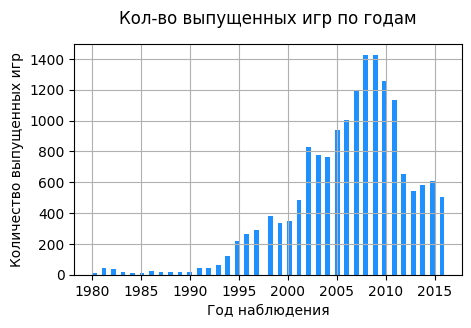

In [22]:
games['year_of_release'].hist(xrot='0', \
                              color = 'DodgerBlue', \
                              figsize=(5, 3), \
                              bins=2*len(games['year_of_release'].unique()))
plt.title('Кол-во выпущенных игр по годам', y=1.05)
plt.xlabel('Год наблюдения')
plt.ylabel('Количество выпущенных игр')

plt.show()

На графике отчетливо видны абсолютные максимумы производства игр к 2009 году, после которого последовал относительно резкий спад, что, с учетом небольшого временного лага, совпадает с динамикой на основных мировых рынках в тот период времени. Спад скорее всего связан не с утратой пользователями интереса к играм как таковым, а с нехваткой средств на их разработку по многим причинам.<br>

Отвечая на поставленный в задании вопрос "Важны ли данные за все периоды?" можно сказать, что ответ зависит от, собственно, того, что предполагается анализировать, какая именно модель будет используется и на какой перспективе. В общем ответ таков: да, важны т.к. они дополняют общую картину поведения исследуемого показателя и помогают определить его поведение в долгосрочной перспективе. Но, вполне вероятно, что на краткосрочной перспективе они не будут использованы для анализа.

## Динамика продаж по платформам.

Найдём платформы с наибольшими суммарными продажами и пострим их распределение по годам. Таким образом мы сможем, например, оценить за какой характерный срок появляются новые и исчезают старые платформы.

In [23]:
platforms_sorted = games.groupby('platform'). \
                         sum(). \
                         sort_values('total_sales', ascending=False). \
                         reset_index()['platform']

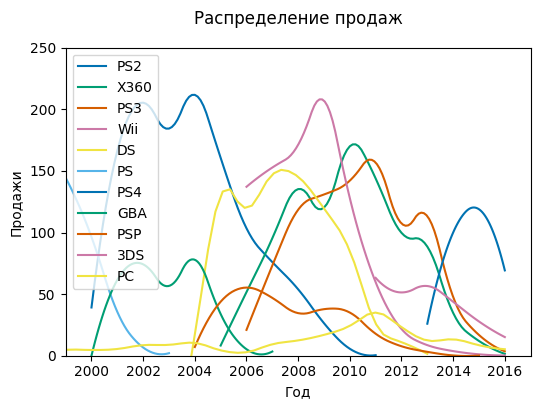

In [24]:
top_10_platforms = platforms_sorted.iloc[0:11]
plt.figure(figsize=(6, 4))
for p in top_10_platforms:
    my_plat_dist(df=games, plat=p, xl=(1999, 2017), yl=(0, 250))

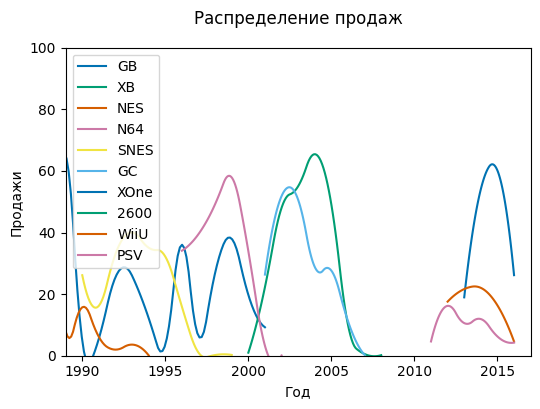

In [25]:
second_10_platforms = platforms_sorted.iloc[11:21]
plt.figure(figsize=(6, 4))
for p in second_10_platforms:
    my_plat_dist(df=games, plat=p, xl=(1989, 2017), yl=(0, 100))

Похоже на разноцветные макаронины на <s>ушах</s> гвоздиках на стене, но тем не менее отсюда напрашиваются некоторые выводы. Их можно подтвердить численно, но, в данном случае, нам будет достаточно визуального анализа.<br>
Очевидно (в данном случае - буквально), что среднее время жизни успешной платформы находится в районе 10 (общее среднее меньше - около 6-7 лет) лет. И, что самое интересное, поскольку мы в 2017 году, сейчас набирает популярность платформа PS4.<br>
P.S. Кстати, интересно посмотреть, набрала ли PS4 популярность далее или нет.

Тем не менее пора немного резюмировать наблюдаемые графики.<br>

Данные:
- На основании наблюдений за динамикой выручки, получаемой с каждой платформы top10 за период с 1990 года и по настоящее (2016) время, можно утверждать, что среднее время жизни успешной платформы находится в районе 10 лет.
- Исходя из средней продолжительности жизни платформы актуальным периодом рассмотрения может является отрезок около 5 лет. За это время платформа уже наберёт динамику и можно будет прогнозировать её поведение в 2017 году.
- Данные старше 5 лет в данном анализе не учитываются.

Потенциально прибыльные платформы:
- В первой десятке практически все платформы находятся на излете своей финансовой жизни и не представляют особого интереса в 2017 году. Тем не менее, на этом фоне, ярко выделяется растущая с 2013 года платформа PlayStation 4 (PS4) - игровая приставка восьмого поколения, выпускаемая японской компанией Sony. По нашей оценке, в 2017 году PS4 должен показать динамику не хуже 2016-го и оставаться генерирующим выручку.
- Из второй десятки, можно выделить платформу XOne - третью по счёту игровую приставку от компании Microsoft, являющуюся преемницей Xbox 360, PSV - портативную консоль от Sony Computer Entertainment, преемник PlayStation Portable и ViiU - игровую консоль Nintendo, которая является преемником Wii.

## Актуальный период.

Рассчитаем медианную продолжительность жизни платформы по имеющимся данным.

In [26]:
temp = games.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1

time_life['life'].median()

7.0

Убираем вторую половину жизненного цикла соответствующую закату платформы и определяем глубину обратного анализа данных начиная от 2017-го года. В итоге получаем дату начала актуального периода (включительно).

In [27]:
actual_period_start_year = 2017 - int(time_life['life'].median() / 2)
actual_period_start_year

2014

Создадим DataFrame содержащий только актуальные данные.

In [28]:
games_actual = games[games['year_of_release'] >= actual_period_start_year]

## График "box plot" для глобальных продаж игр в разбивке по платформам.

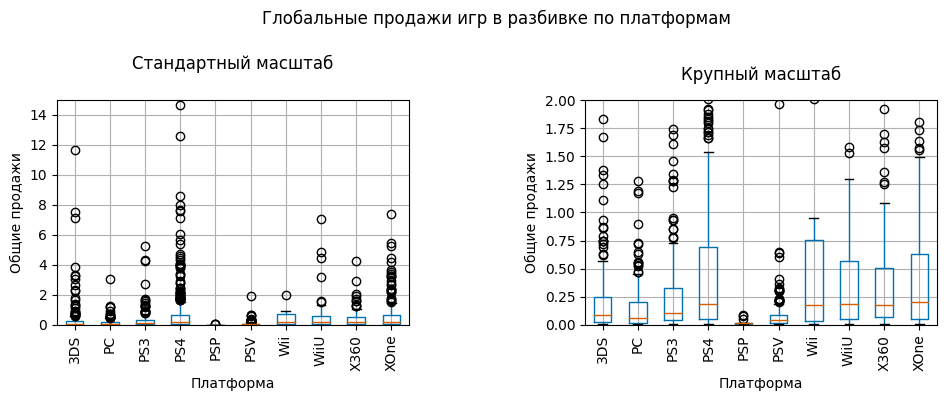

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(11, 3))

games_actual.boxplot(column='total_sales', by='platform', ax=ax[0])
games_actual.boxplot(column='total_sales', by='platform', ax=ax[1])
plt.suptitle('Глобальные продажи игр в разбивке по платформам', y=1.2)

ax[0].set_title('Стандартный масштаб', y=1.1)
ax[0].set_xlabel('Платформа')
ax[0].set_ylabel('Общие продажи')
ax[0].set_ylim([0, 15])
ax[0].tick_params(axis='x', labelrotation=90)

ax[1].set_title('Крупный масштаб', y=1.05)
ax[1].set_xlabel('Платформа')
ax[1].set_ylabel('Общие продажи')
ax[1].set_ylim([0, 2])
ax[1].tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(wspace=0.5)
plt.show()

"Ящики с усами" по глобальным продажам игр в разбивке по платформам построены. Описываем результат:<br>

Результат жизненный. Средние (точнее медианные) уровни продаж игр у всех платформ примерно в одном диапазоне около 0.2М. Над этими середнячками выбросами находится конгломерат высокобюджетных игр, которые и "делают" этот рынок. Это особенно хорошо видно на не масштабированном графике. Ну и, конечно, PS4 выглядит очень перспективно, показывая стабильно высокие (относительно медианных) продажи. Кроме PS4 можно выделить такие платформы как XOne и WiiU, основная выручка на которых также находится выше медианного значения.

## Зависимость продаж от отзывов пользователей и критиков.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

### PlayStation 4.

Возьмём данные по самой перспективной платформе - PlayStation 4.

In [30]:
ps4 = games_actual[games_actual['platform'] == 'PS4']

И построим scatter график.

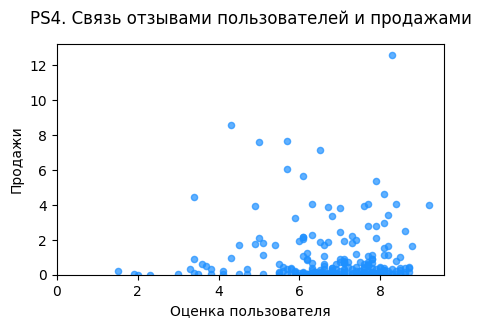

In [31]:
ps4.plot(x='user_score', \
         y='total_sales', \
         kind='scatter', \
         xlim=(0), \
         ylim=(0), \
         alpha=0.7, \
         figsize=(5,3), \
         color='DodgerBlue')
plt.xlabel('Оценка пользователя')
plt.ylabel('Продажи')
plt.title('PS4. Связь отзывами пользователей и продажами', y=1.05)
plt.show()

А также посчитаем корреляцию между выручкой на PlayStation 4 и оценками пользователей.

In [32]:
ps4['user_score'].corr(ps4['total_sales']).round(2)

-0.04

Такие же расчеты проведем для оценок критиков.

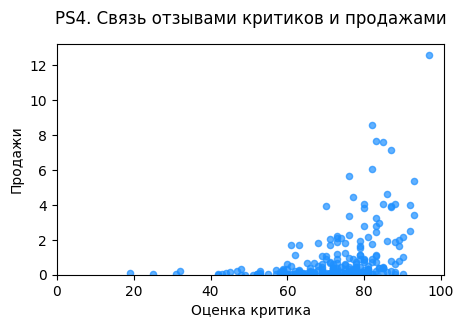

In [33]:
ps4.plot(x='critic_score', \
         y='total_sales', \
         kind='scatter', \
         xlim=(0), \
         ylim=(0), \
         alpha=0.7, \
         figsize=(5,3), \
         color='DodgerBlue')
plt.xlabel('Оценка критика')
plt.ylabel('Продажи')
plt.title('PS4. Связь отзывами критиков и продажами', y=1.05)
plt.show()

In [34]:
ps4['critic_score'].corr(ps4['total_sales']).round(2)

0.4

На основании вышеприведённых данных можно видеть, что оценки критиков действительно положительно связаны с генерируемой PS4 выручкой, в то время как оценки пользователей никак с ней не коррелируют. Тем не менее, сами значения корреляций находятся существенно ниже тех, которые можно было бы считать высокой положительной корреляцией. Однако, в случае высокобюджетных игр можно говорить о том, что увеличение бюджета обычно приводит к увеличению как пользовательского рейтинга, так и рейтинга критиков.

### Сравнение с другими платформами.

Соответствуют ли наши предположения по отдельно взятой платформе PlayStation 4 другим платформам? Проверим.

Возьмём оставшиеся шесть после PS4 платформ, генерирующие наибольшую выручку.

In [35]:
plat_6 = games_actual.pivot_table(index='platform', values='total_sales', aggfunc='sum').\
                      reset_index().\
                      sort_values(by='total_sales', ascending=False)['platform'].\
                      iloc[1:7].\
                      reset_index(drop=True)

Это следующие платформы:

In [36]:
HTML(pd.DataFrame(plat_6).T.to_html())

,0,1,2,3,4,5
platform,XOne,3DS,PS3,X360,WiiU,PC


#### Зависимость от отзывов пользователей.

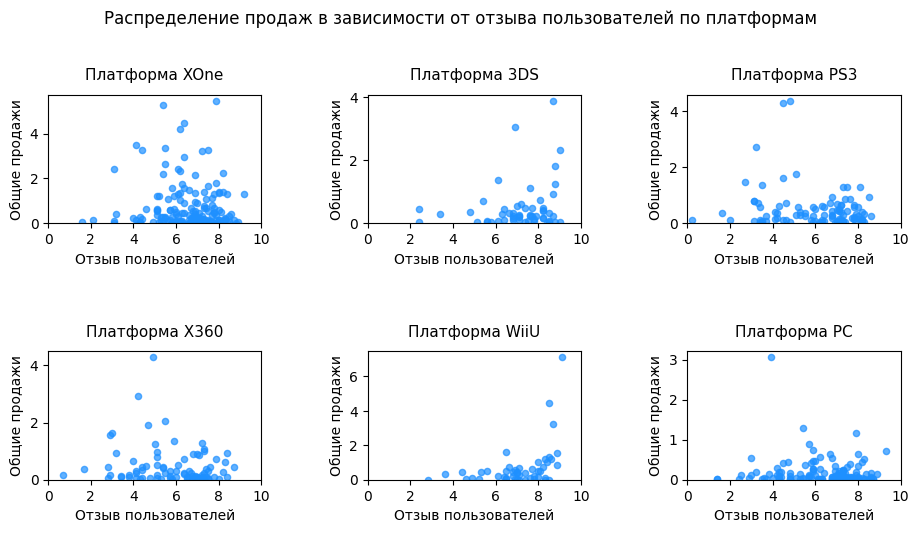

In [37]:
my_sales_dist_by_score_by_plt(score='user', plat=plat_6, data=games_actual)

Визуально схоже с ситуацией с PS4, но посмотрим корреляциями по платформам.

In [38]:
for p in plat_6:
    games_p = games_actual[games_actual['platform'] == p]
    corr_p = games_p['user_score'].corr(games_p['total_sales'])
    print(f'Платформа: {p}. Корреляция между продажами и пользовательским отзывом: {corr_p:.2f}')

Платформа: XOne. Корреляция между продажами и пользовательским отзывом: -0.07
Платформа: 3DS. Корреляция между продажами и пользовательским отзывом: 0.22
Платформа: PS3. Корреляция между продажами и пользовательским отзывом: -0.17
Платформа: X360. Корреляция между продажами и пользовательским отзывом: -0.14
Платформа: WiiU. Корреляция между продажами и пользовательским отзывом: 0.41
Платформа: PC. Корреляция между продажами и пользовательским отзывом: -0.07


3DS и WiiU оказались более чувствительны к пользовательским отзывам (или наоборот, пользовательские отзывы более чувствительны к 3DS и WiiU).<br>
В остальных платформах наблюдаются странные отрицательные значения корреляции, однако их абсолютные значения говорят об отсутствии корреляции с пользовательскими отзывами как таковыми.<br>

#### Зависимость от отзыва критиков.

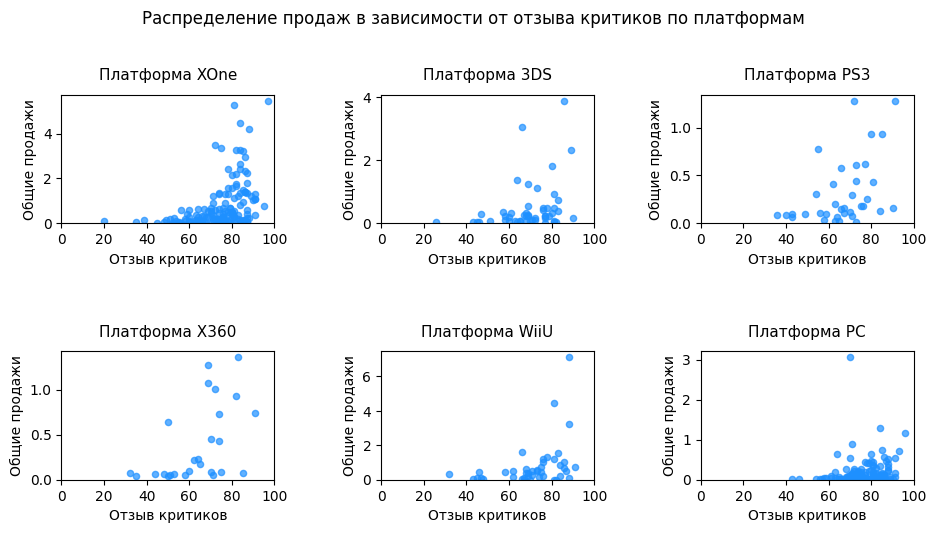

In [39]:
my_sales_dist_by_score_by_plt(score='critic', plat=plat_6, data=games_actual)

In [40]:
for p in plat_6:
    games_p = games_actual[games_actual['platform'] == p]
    corr_p = games_p['critic_score'].corr(games_p['total_sales'])
    print(f'Платформа: {p}. Корреляция между продажами и отзывом критиков: {corr_p:.2f}')

Платформа: XOne. Корреляция между продажами и отзывом критиков: 0.43
Платформа: 3DS. Корреляция между продажами и отзывом критиков: 0.31
Платформа: PS3. Корреляция между продажами и отзывом критиков: 0.45
Платформа: X360. Корреляция между продажами и отзывом критиков: 0.53
Платформа: WiiU. Корреляция между продажами и отзывом критиков: 0.37
Платформа: PC. Корреляция между продажами и отзывом критиков: 0.17


Все значения близки к уровню PS4 и есть смысл отметить, что у критиков высокобюджетные игры вызывают более положительные отзывы.<br>
Этот феномен можно объяснить тем фактом, что в большинстве случаев более высокий бюджет игры обычно обеспечивает более качественный контент.<br>
Но, по-прежнему, эти значения корреляций говорят лишь о наличии слабовыраженной корреляции между продажами на платформе и отзывом критиков.

## Распределение игр по жанрам.

### Распределение количества игр по жанрам.

Посмотрим распределение количества игр по жанрам.

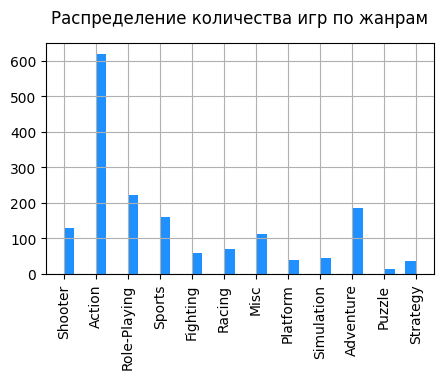

In [41]:
games_actual['genre'].hist(xrot='90', \
                           color = 'DodgerBlue', \
                           figsize=(5, 3), \
                           bins=my_sturges(len(games['genre'])))
#                           bins=11)
plt.title('Распределение количества игр по жанрам', y=1.05)
plt.show()

В общем распределении количества игр по жанрам жанр <i>Action</i> лидирует. Затем следуют ролевые игры, приключения, спорт и всякая всячина. А вот разгадывать загадки и строить стратегии (впрочем как и скакать по кубикам) видимо никто не любит. Возможно, эта информация нам пригодится дальше.

Но что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами? И, при этом, у нас есть только косвенные данные.<br>
Сначала посмотрим, что нам говорит теория:

>Оценка прибыльности видеоигр по жанрам может быть достаточно сложной задачей, особенно если имеются только данные за несколько лет по выручке на разных платформах. Однако, можно использовать несколько подходов для проведения такой оценки.
>- Анализ трендов: можно проанализировать, какие жанры игр наиболее популярны среди пользователей в последние годы, и установить, какие жанры находятся в тенденции роста. В зависимости от этого, можно сделать выводы о том, какие жанры игр, скорее всего, будут прибыльными в ближайшем будущем.
>- Анализ рыночной доли: можно проанализировать рыночную долю каждого жанра на основе данных о продажах на разных платформах. Если жанр занимает значительную долю рынка, это может свидетельствовать о том, что он прибыльный.
>- Анализ отзывов пользователей и критиков: можно проанализировать оценки пользователей и критиков на различные игры в каждом жанре, чтобы установить, какие жанры игр пользуются высоким спросом среди пользователей. Если игры в конкретном жанре получают высокие оценки от пользователей и критиков, это может свидетельствовать о том, что этот жанр прибыльный.
>- Анализ продаж по регионам: можно проанализировать, какие жанры игр наиболее популярны в разных регионах мира. Некоторые жанры могут быть более популярны в одних регионах, чем в других, и это может влиять на прибыльность игр в этих жанрах.

Но следует, конечно, учитывать, что оценка прибыльности игр может зависеть от многих факторов, таких как бюджет разработки, маркетинговые затраты, конкуренция и прочее.

Анализ продаж по регионам и Анализ рыночной доли будут сделаны в следующем разделе, Анализ отзывов пользователей и критиков мы уже провели. Таким образом нам осталось проанализировать, какие жанры игр наиболее популярны среди пользователей в последние годы, и установить, какие жанры находятся в тенденции наименьшего отрицательного роста и, желательно, всё ещё показывают неплохую выручку.

### Распределение выручки по жанрам.

Для начала - первые пять лидеров жанра по выручке на рынке в порядке убывания по списку:

In [42]:
games_actual_by_genre_sales = games_actual.pivot_table(index='genre', \
                                                       values='total_sales', \
                                                       columns='year_of_release', \
                                                       aggfunc='sum', \
                                                       margins=True)

In [43]:
games_actual_by_genre_sales_sorted = games_actual_by_genre_sales.reset_index().\
                                                                 sort_values(by='All', ascending=False).\
                                                                 reset_index(drop=True).\
                                                                 iloc[1:6]

In [44]:
genres_top5 = games_actual_by_genre_sales_sorted['genre']
HTML(pd.DataFrame(genres_top5).T.to_html())

,1,2,3,4,5
genre,Action,Shooter,Sports,Role-Playing,Misc


И постоим для них график выручки по годам актуального наблюдения:

In [45]:
games_actual_by_genre_sales_sorted_t = games_actual_by_genre_sales_sorted.set_index('genre').\
                                                                          T.\
                                                                          iloc[0:3]

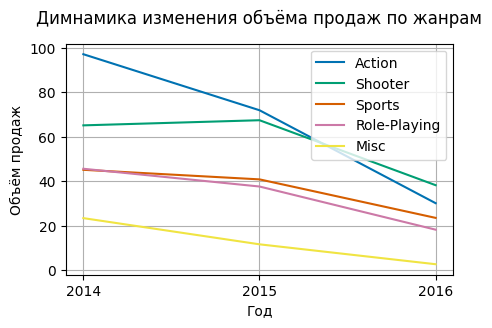

In [46]:
plt.figure(figsize=(5, 3))
for i in genres_top5:
    plt.plot(games_actual_by_genre_sales_sorted_t.index, \
             games_actual_by_genre_sales_sorted_t[i], \
             label=i)
plt.xlabel('Год')
plt.ylabel('Объём продаж')
plt.xticks([2014, 2015, 2016], rotation=0)
plt.grid()
plt.legend(loc='upper right')
plt.title('Димнамика изменения объёма продаж по жанрам', y=1.05)
plt.show()

Этот график нам ничего не скажет о прибыли, но он интересен тем, что в 2016 году жанр компьютерных игр Shooter начал показывать большую выручку, чем ранее лидировавший жанр Action. Хотя мы уже обращали внимание на тот факт, что общая выручка, в общем случае, не точно характеризует рассматриваемый жанр.

### Медианные значения и прибыльность жанра.

Мы помним, что рассматриваемая индустрия компьютерных игр характеризуется чрезвычайно существенными выбросами значений выручки по всем параметрам и если одна платформа со своей одной игрой в каком-то жанре выстрелила, а остальные провалились, то все равно будет виден максимум общих продаж. Для прибыльности нужны стабильные жанры, который приносят доход не зависимо от платформы, и следовательно, на этот жанр есть устойчивый спрос. Эти рассуждения приводят нас к сравнению медианных продаж, которые потом мы проиллюстрируем диаграммами размаха.

In [47]:
# Let's shorten these long variable names
gms_act_gen_sl_med = games_actual.pivot_table(index='genre', \
                                              values='total_sales', \
                                              columns='year_of_release', \
                                              aggfunc='median').reset_index()

И рассчитаем стандартное отклонение этих медиан.

In [48]:
gms_act_gen_sl_med['std'] = gms_act_gen_sl_med.loc[:, [2014, 2015, 2016]].std(axis=1)

Определим, какое место в новом рейтинге они теперь занимает пятёрка лидеров по выручке по итогам 2016-го года:

In [49]:
gms_act_gen_sl_med.sort_values(by=2016, ascending=False).iloc[0:10].reset_index(drop=True)

year_of_release,genre,2014,2015,2016,std
0,Shooter,0.66,0.92,0.24,0.35
1,Role-Playing,0.11,0.11,0.12,0.01
2,Sports,0.46,0.12,0.12,0.20
3,Platform,0.83,0.10,0.10,0.42
4,Fighting,0.13,0.10,0.08,0.02
5,Strategy,0.06,0.04,0.06,0.01
6,Racing,0.17,0.15,0.05,0.06
7,Action,0.21,0.07,0.05,0.08
8,Misc,0.16,0.19,0.04,0.08
9,Simulation,0.12,0.20,0.02,0.09


Shooter - со второго места поднялся на первое.<br>
Role-Playing - с четвертого места поднялся на второе.<br>
Sports - остался на третьем месте.<br>
Action - с первого места опустился на восьмое.<br>
Misc - с пятого места опустился на девятое.<br>


Не просто так Action потерял в общей выручке перед Shooter. И какая большая разница в медианах. Здесь наглядно видно огромное влияние выбросов на средне-суммарные расчёты. Тем не менее, что можно уже сказать по прибыльности жанров в разрезе концепции о стабильности жанра и его медианного значения продаж.

Посмотрим с медианной точки зрения на новую пятерку лидеров:

In [50]:
gms_act_gen_sl_med.sort_values(by=2016, ascending=False).iloc[0:5].reset_index(drop=True)

year_of_release,genre,2014,2015,2016,std
0,Shooter,0.66,0.92,0.24,0.35
1,Role-Playing,0.11,0.11,0.12,0.01
2,Sports,0.46,0.12,0.12,0.20
3,Platform,0.83,0.10,0.10,0.42
4,Fighting,0.13,0.10,0.08,0.02


<b>Shooter</b>. По величине медианной выручки и её относительной стабильности на протяжении как минимум трех лет, можно сказать, что бизнес в этой нише вполне обустроен и прибылен. В 2017-м можно ожидать продолжение этого тренда, но большое значение стандартного отклонения в этом жанре говорит о повышенной волатильности в показателях деятельности и определённых рисках в прогнозировании на 2017 год.<br>
<b>Role-Playing</b> Это самый стабильный из жанров, характеризующийся минимальным стандартным отклонением в пятёрке новых лидеров, однако по величине медианной выручки можно ожидать и небольших показателей прибыльности. Но это классика. Менее рискованный инструмент - менее прибыльный инструмент.

Проиллюстрируем всё вышесказанное диаграммами размаха. В полном масштабе и в укрупнённом:

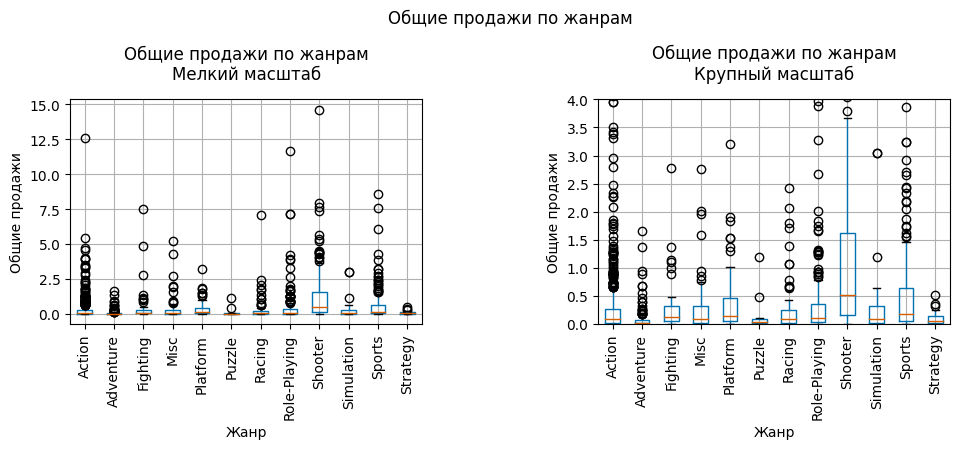

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(11, 3))

games_actual.boxplot(column='total_sales', by='genre', ax=ax[0])
games_actual.boxplot(column='total_sales', by='genre', ax=ax[1])
plt.suptitle('Общие продажи по жанрам', y=1.2)

ax[0].set_title('Общие продажи по жанрам\nМелкий масштаб', y=1.05)
ax[0].set_xlabel('Жанр')
ax[0].set_ylabel('Общие продажи')
ax[0].tick_params(axis='x', labelrotation=90)

ax[1].set_title('Общие продажи по жанрам\nКрупный масштаб', y=1.05)
ax[1].set_xlabel('Жанр')
ax[1].set_ylabel('Общие продажи')
ax[1].set_ylim([0, 4])
ax[1].tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(wspace=0.5)
plt.show()

Эффективность жанра Shooter - налицо.

## Краткий вывод.

С учетом небольшой задержки по времени, график выручки компьютерных игр совпадает с динамикой основных мировых рынков в рассматриваемый период. Существенный спад после 2009 года следует за рынками в целом, и общая выручка скорее всего, будет соответствовать биржевой динамике в будущем.

Из анализа динамики выручки, получаемой от каждой платформы из топ-10 за период с 1990 года по настоящее время, можно сделать вывод, что среднее время жизни успешной платформы составляет около 7 лет. Исходя из этого, актуальным периодом рассмотрения может являться отрезок длиной примерно в 3-4 года. В этой связи началом актуального периода становится 2014-й год.

Средние, или точнее медианные, уровни продаж игр на всех платформах находятся примерно в одном диапазоне около 0.2М. Однако над этими средними значениями находятся выбросы - высокобюджетные игры, которые играют ключевую роль в формировании рынка. Эта закономерность особенно хорошо видна на графике, который не масштабирован. Кроме того, стоит отметить, что PS4 выглядит очень перспективно, тогда как Xbox One от Microsoft, PSV от Sony и ViiU от Nintendo значительно отстают в продажах.

Оценки критиков действительно положительно связаны с генерируемой одной из популярных платформ PS4 выручкой, в то время как оценки пользователей никак с ней не коррелируют. Тем не менее, сами значения корреляций находятся существенно ниже тех, которые можно было бы считать высокой положительной корреляцией. Однако, в случае высокобюджетных игр можно говорить о том, что увеличение бюджета обычно приводит к увеличению как пользовательского рейтинга, так и рейтинга критиков.

Для других платформ все значения оценок близки к показателям PS4 и есть смысл отметить, что у критиков высокобюджетные игры вызывают более положительные отзывы. Этот феномен можно объяснить тем фактом, что в большинстве случаев более высокий бюджет игры обычно обеспечивает более качественный контент.
Но, по-прежнему, эти значения корреляций существенно ниже утверждения о высокой корреляции.

Лидером среди жанров по выручке является "Action". Но, с точки зрения прибыльности жанра, анализ медианных значений выручки и их стабильности на рассматриваемом отрезке времени является жанр "Shooter". Хотя в тоже время он наиболее рискован с точки зрения прогнозирования. Наиболее стабильный "Role-Playing" производит наименьшее количество прибыли.

# Портрет пользователя каждого региона (на 2017 год).

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.15.75804.JPG" width="110" align="left"/>Портрет пользователя (User persona) - это описание вымышленного представителя целевой аудитории, которое используется в маркетинге и UX-дизайне для создания более эффективных продуктов и решений. В data analysis портрет пользователя может использоваться для более точной идентификации целевой аудитории и анализа ее поведения и потребностей.

Портрет пользователя является важным инструментом в data analysis, так как он помогает увидеть целевую аудиторию в целом, а не только отдельных пользователей. Это позволяет создать более эффективные стратегии маркетинга, улучшить пользовательский опыт и повысить удовлетворенность клиентов.<br clear="left"/>

## Cividis.

В этом разделе будут использоваться круговые диаграммы. Для подобного вида диаграмм используем цветовую палитру Cividis. Она была разработана научными исследователями специально для обеспечения более точного визуального восприятия графиков людьми с различными формами ограничения цветового восприятия.

## Жанры и платформы.

Сразу опишем основные жанры и консоли, чтобы в дальнейшем не перегружать текст.

### Платформы.

- <b>Nintendo 3DS</b> - это портативная игровая консоль, выпущенная компанией Nintendo в 2011 году. Она имеет два экрана - один из которых является сенсорным, поддерживает 3D-графику без необходимости ношения специальных очков, а также имеет встроенный датчик движения и поддерживает возможность игры в мультиплеер через Wi-Fi. Nintendo 3DS предназначена для игры в портативном формате и выпускается в различных цветовых вариантах.
- <b>PlayStation 4</b> - это домашняя игровая консоль, выпущенная компанией Sony в 2013 году. Она является четвертой по счету консолью PlayStation и имеет большую библиотеку игр, включая эксклюзивы от студий Sony и других издателей. PS4 поддерживает игры с высоким разрешением, в том числе с поддержкой технологии HDR, а также позволяет стримить игры на ПК и устройствах под управлением iOS и Android. Консоль также имеет возможность игры в мультиплеер и доступ к онлайн-магазину PlayStation Store, где можно приобрести игры и дополнительный контент.
- <b>PlayStation Vita</b> - это портативная игровая консоль, выпущенная компанией Sony в 2011 году. Она имеет сенсорный OLED-экран, встроенные камеры, микрофон, датчики движения и GPS, а также поддерживает Wi-Fi, Bluetooth и 3G-связь (зависит от модели). PS Vita также имеет возможность игры в мультиплеер через Wi-Fi и поддерживает доступ к онлайн-магазину PlayStation Store, где можно приобрести игры и дополнительный контент. Однако, в связи с неудовлетворительной продажей консоли, Sony прекратила ее производство в 2019 году и больше не выпускает игры для нее.
- <b>PlayStation 3</b> - это домашняя игровая консоль, выпущенная компанией Sony в 2006 году. PS3 имеет мощный процессор, графический чип и большую жесткую диск, позволяющие играть в игры высокого качества и воспроизводить фильмы в HD-качестве. Консоль также имеет встроенный Blu-ray-плеер и поддерживает интернет-соединение через Wi-Fi или Ethernet-кабель. PS3 поддерживает игры с мультиплеером и имеет доступ к PlayStation Network, где можно приобрести игры и дополнительный контент. В 2013 году Sony выпустила более новую консоль PlayStation 4, но PS3 продолжала продаваться и поддерживаться до 2017 года.
- <b>Wii U</b> - это игровая консоль, выпущенная компанией Nintendo в 2012 году. Wii U имеет уникальный геймпад с сенсорным экраном, который позволяет играть в игры как на телевизоре, так и на геймпаде. Консоль также поддерживает игры в HD-качестве и имеет встроенный NFC-сканер для работы с фигурками amiibo. Wii U поддерживает мультиплеер и доступ к интернет-сервисам, включая Nintendo eShop, где можно приобрести игры и дополнительный контент. В 2017 году Nintendo выпустила свою последнюю консоль, Nintendo Switch, и прекратила производство Wii U.
- <b>Xbox One</b> - это игровая консоль компании Microsoft, которая была выпущена в ноябре 2013 года. Xbox One была разработана как преемник Xbox 360 и имеет более продвинутую аппаратную начинку и новые функции, такие как поддержка голосовых команд, встроенный контроллер Kinect, возможность запуска нескольких приложений одновременно и т.д. Xbox One поддерживает множество игр различных жанров, таких как шутеры, спортивные игры, гонки, RPG и др. Кроме того, консоль имеет доступ к различным онлайн-сервисам, таким как Xbox Live, который позволяет игрокам играть вместе в режиме многопользовательской игры, загружать новые игры и дополнения, смотреть фильмы и телепередачи, а также общаться с другими игроками. Xbox One также имеет возможность проигрывать Blu-ray-диски и подключаться к интернету для просмотра потокового видео и музыки. Кроме того, она обладает некоторыми дополнительными функциями, такими как возможность использовать приложения со смартфонов и планшетов, а также встроенный диктофон и Skype для связи с другими игроками.
- <b>Xbox 360</b> - это игровая консоль, выпущенная компанией Microsoft в 2005 году. Она является преемником оригинальной Xbox и имеет более мощную аппаратную часть и расширенные возможности, такие как поддержка высокой четкости и беспроводных контроллеров. X360 имеет множество игр различных жанров, таких как шутеры, экшн, RPG, гонки, спортивные и др. Кроме того, консоль позволяет игрокам скачивать игры, дополнительный контент и приложения через интернет-магазин Xbox Live Marketplace. Консоль также имеет возможность воспроизводить DVD и Blu-ray диски, а также стримить видео и музыку через подключение к домашней сети. X360 также предоставляет доступ к социальным функциям, таким как общение с друзьями и другими игроками через Xbox Live, а также возможность делиться своими достижениями и скриншотами с другими.
- <b>PC</b> (Personal Computer) - это платформа для компьютерных игр, которая охватывает широкий спектр аппаратных и программных решений. Компьютеры могут быть настроены и обновлены для улучшения производительности и графики, что делает PC наиболее гибкой и масштабируемой платформой для игр. Одним из преимуществ игр на PC является большой выбор игр и жанров, доступных для скачивания и установки. Игры на PC доступны как в цифровом, так и в физическом формате, и могут быть приобретены через множество онлайн-магазинов, таких как Steam, GOG, Epic Games Store, и др. Кроме того, игры на PC могут иметь более высокое качество графики и могут работать на более высоком разрешении, чем игры на консолях. Игры на PC также могут быть модифицированы и настроены с помощью различных программ и утилит, что позволяет создавать уникальный игровой опыт. PC также предоставляет возможность играть в игры с использованием различных устройств ввода, таких как клавиатура и мышь, геймпады, джойстики и рули. Игры на PC также поддерживают онлайн-многопользовательские режимы, что позволяет игрокам играть с другими игроками из любой точки мира.

### Жанры.

- <b>Жанр компьютерных игр Role-Playing (RPG)</b>. Один из самых популярных и распространенных жанров. RPG-игры обычно предлагают игрокам управлять одним или несколькими персонажами в вымышленном мире, в котором они могут взаимодействовать с другими персонажами, выполнять задания, исследовать мир и развивать своих персонажей. В RPG-играх обычно есть глубокая и захватывающая история, которая может быть линейной или нелинейной. Некоторые известные RPG-игры включают в себя серии Final Fantasy, The Elder Scrolls, Dragon Age, Fallout, The Witcher, Mass Effect и многие другие.
- <b>Жанр компьютерныхй игр Action</b>. Включают в себя много действий, сражений, боя и приключений. В играх этого жанра игрок управляет персонажем, который должен преодолевать препятствия и сражаться с противниками, используя различное оружие и навыки. Также, в играх этого жанра могут быть элементы головоломок, платформеры и элементы RPG. Жанр Action включает в себя множество поджанров, таких как экшен-приключения, шутеры от первого лица, файтинги, гонки и т.д. Некоторые известные игры этого жанра включают в себя серии Grand Theft Auto, Call of Duty, Assassin's Creed, Uncharted, Tomb Raider, Devil May Cry и многие другие.
- <b>Жанр компьютерных игр Fighting</b> (файтинги). Жанр игр, в которых игрок управляет бойцом, сражающимся с другими бойцами в один на один боях. Файтинги, как правило, включают в себя множество различных ударов и комбинаций, которые игрок может использовать, чтобы победить противника. Файтинги имеют глубокую историю, начиная с классических игр, таких как Street Fighter и Mortal Kombat, и до современных игр, таких как Tekken и Soul Calibur. Кроме того, существуют также различные субжанры файтингов, такие как 2D-файтинги, 3D-файтинги, аркадные файтинги и др.
- <b>Жанр компьютерных игр Misc</b> (miscellaneous, разное). Относится к играм, которые не подходят под определенный жанр или сочетают элементы разных жанров. Они часто включают в себя элементы различных игровых жанров, таких как RPG, экшен, головоломки и т. д. Такие игры могут предоставлять игрокам широкий спектр игровых опций и могут варьироваться от стратегических и симуляторов до спортивных и казуальных игр. Примерами игр в жанре Misc могут быть такие, как Minecraft, Goat Simulator, The Sims, Scribblenauts и др. Эти игры могут иметь очень различный геймплей и стиль, и часто выделяются своей оригинальностью и творческим подходом.
- <b>Жанр компьютерных игр Shooter</b> (стрелялки). Представляет собой игры, в которых основной игровой процесс заключается в использовании оружия и стрельбе. В играх этого жанра игрок обычно управляет персонажем от первого или третьего лица и использует оружие, чтобы атаковать врагов и выполнить цели. Они могут иметь различные сеттинги, от современной военной тематики до фантастических или постапокалиптических миров. Шутеры часто включают в себя элементы экшена и стратегии, и могут быть как одиночными играми, так и многопользовательскими, в которых игроки могут сражаться друг с другом в режиме онлайн. Примерами игр в жанре шутеров могут быть такие, как Call of Duty, Battlefield, Counter-Strike, Halo и др.
- <b>Жанр компьютерных игр Sports</b> (спортивные игры) включает в себя игры, которые имитируют различные виды спорта. Эти игры часто имеют лицензионные соглашения с профессиональными спортивными организациями, позволяя игрокам играть за настоящие команды и спортсменов. В играх жанра Sports игроки могут участвовать в различных видов спорта, таких как футбол, баскетбол, бейсбол, хоккей, гольф, теннис, бокс и т.д. В них могут быть включены как одиночные, так и многопользовательские режимы игры, и режимы, в которых игроки могут создавать своих собственных спортсменов и команды. Спортивные игры могут предоставлять различные функции и возможности, такие как управление командой, управление тренировкой и стратегией, а также управление финансами и симуляция жизни спортсмена. Игры в этом жанре могут иметь различную сложность, от легких до сложных, и могут предоставлять игрокам уникальный спортивный опыт, которого не получить в реальной жизни.

## Япония.

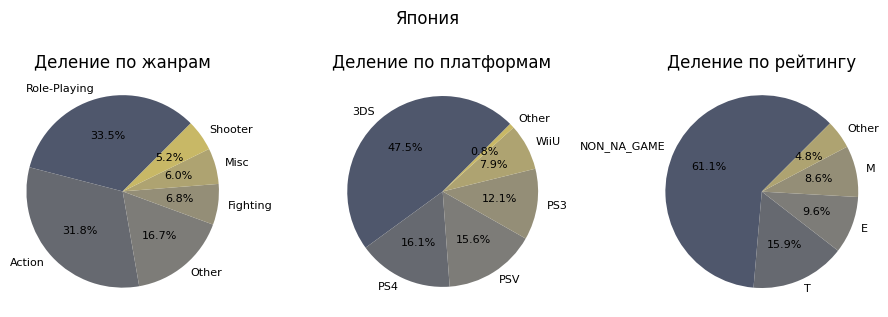

In [52]:
fig, ax = plt.subplots(ncols=3, figsize=(11, 3))
fig.suptitle('Япония', y=1.1)
my_user_persona_new(df=games_actual, reg_sales='jp_sales', per='genre', ax=ax[0])
my_user_persona_new(df=games_actual, reg_sales='jp_sales', per='platform', ax=ax[1])
my_user_persona_new(df=games_actual, reg_sales='jp_sales', per='rating', ax=ax[2])
plt.subplots_adjust(wspace=0.5)
plt.show()

### Самые популярные платформы (топ-5).

- Nintendo 3DS (47.5 общих продаж игр).
- PlayStation 4 (16.1% общих продаж игр).
- PlayStation Vita (15.7% общих продаж игр).
- PlayStation 3 (12% общих продаж игр).
- Wii U (7.8% общих продаж игр).

### Самые популярные жанры (топ-5).

- Жанр компьютерных игр Role-Playing (RPG) (33.5%).
- Жанр компьютерной игры Action (31.7%).
- Жанр компьютерных игр Fighting (файтинги)(6.8%).
- Жанр компьютерных игр Misc (miscellaneous, разное) (6%).
- Жанр компьютерных игр Shooter (стрелялки) (5.2%).

### Рейтинг ESRB.

Рейтинг ESRB не оказывает существенного влияния на продажи т.к. в данном регионе большей популярностью пользуются игры местного производства.

### User persona.

Типичный user persona игрока на 3DS в жанре role-playing категории 'T' из Японии:

Имя: Харука<br>
Пол: Женский<br>
Возраст: 24 года<br>
Профессия: Офисный работник<br>

Хобби: Игры на 3DS, чтение манги, смотреть аниме, коллекционирование фигурок аниме-персонажей.

Характеристики игровой активности:

- Харука - опытный игрок на 3DS, предпочитающая игры жанра role-playing японского производства.
- Она ценит такие игры за их интересный сюжет, геймплей и уникальный стиль анимации.
- Харука любит игры, которые позволяют ей наслаждаться красивой графикой и музыкой, а также приятной и позитивной атмосферой.
- Она играет в основном в одиночные игры, так как это позволяет ей глубоко погрузиться в сюжет и насладиться игрой в своем темпе.
- Харука часто играет в свободное время после работы, в дороге или в выходные дни, и это для нее способ расслабиться и отдохнуть от повседневных забот.
- Она также любит обмениваться мнениями о играх со своими друзьями и участвовать в онлайн-форумах и сообществах, чтобы узнать новую информацию о своих любимых играх и поделиться своим опытом с другими игроками.

## Северная Америка.

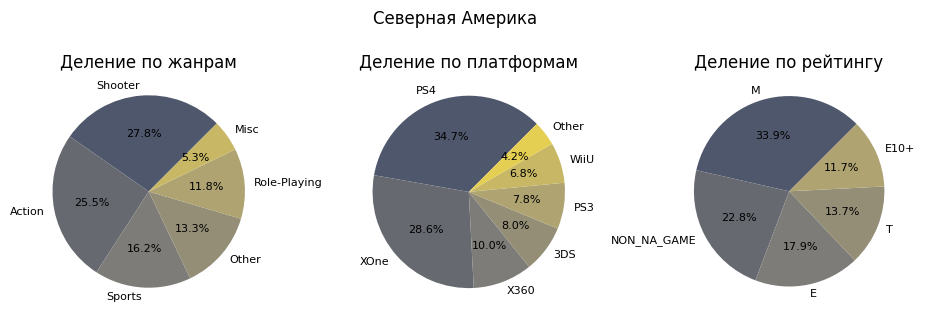

In [53]:
fig, ax = plt.subplots(ncols=3, figsize=(11, 3))
fig.suptitle('Северная Америка', y=1.1)
my_user_persona_new(df=games_actual, reg_sales='na_sales', per='genre', ax=ax[0])
my_user_persona_new(df=games_actual, reg_sales='na_sales', per='platform', ax=ax[1])
my_user_persona_new(df=games_actual, reg_sales='na_sales', per='rating', ax=ax[2])
plt.subplots_adjust(wspace=0.5)
plt.show()

### Самые популярные платформы (топ-5).

- PlayStation 4 (34.7% общих продаж игр).
- Xbox One (28.6% общих продаж игр).
- Xbox 360 (10% общих продаж игр).
- Nintendo 3DS (8% общих продаж игр).
- PlayStation 3 (7.8% общих продаж игр).

### Самые популярные жанры (топ-5).

- Жанр компьютерных игр Shooter (стрелялки) (27.8%).
- Жанр компьютерной игры Action (25.5%).
- Жанр компьютерной игры Sports (16.2%).
- Жанр компьютерных игр Role-Playing (RPG) (11.8%).
- Жанр компьютерных игр Misc (miscellaneous, разное) (5.3%).

### Рейтинг ESRB.

Рейтинг ESRB оказывает существенное влияния на продажи т.к. в данном регионе большей популярностью пользуются игры местного производства.

### User persona.

Типичный user persona игрока в жанрах Shooter на PlayStation 4 категории 'M' из Северной Америки:

Имя: Джейкоб<br>
Пол: Мужской<br>
Возраст: 25 лет<br>
Профессия: Сотрудник службы безопасности<br>

Хобби: Игра в компьютерные игры, занятие спортом и фитнесом, просмотр фильмов и телешоу.

Характеристики игровой активности:

- Джейкоб - опытный игрок в шутеры и играет в них на PS4 уже много лет.
- Он предпочитает игры категории "M", так как они содержат насилие, реализм и разнообразные механики игры.
- Джейкоб играет как в одиночные, так и в многопользовательские режимы, но предпочитает последние, так как это позволяет ему соревноваться с другими игроками.
- Он проводит в играх много времени, уделяя особое внимание тактике, стратегии и координации с командой.
- Джейкоб играет в компьютерные игры после работы и в выходные дни, и это для него способ расслабиться и отвлечься от повседневных забот.
- Он также участвует в онлайн-турнирах и чемпионатах по играм, чтобы испытать свои навыки и выиграть призы.

## Европа.

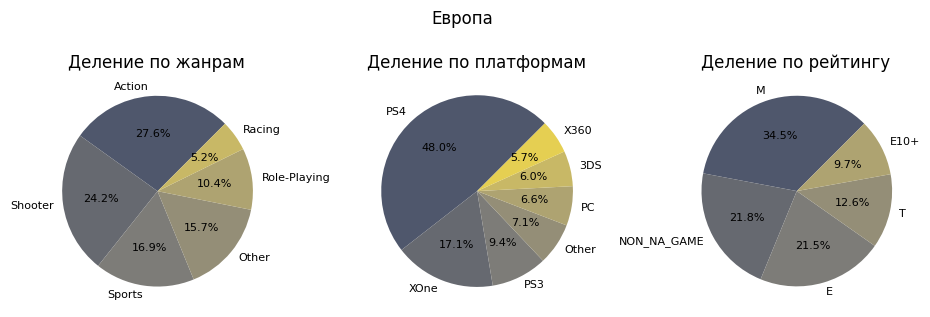

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(11, 3))
fig.suptitle('Европа', y=1.1)
my_user_persona_new(df=games_actual, reg_sales='eu_sales', per='genre', ax=ax[0])
my_user_persona_new(df=games_actual, reg_sales='eu_sales', per='platform', ax=ax[1])
my_user_persona_new(df=games_actual, reg_sales='eu_sales', per='rating', ax=ax[2])
plt.subplots_adjust(wspace=0.5)
plt.show()

### Самые популярные платформы (топ-5).

- PlayStation 4 (48% общих продаж игр).
- Xbox One (17.1% общих продаж игр).
- PlayStation 3 (9.4% общих продаж игр).
- PC (Personal Computer) (6.6% общих продаж игр).
- Nintendo 3DS (6% общих продаж игр).

### Самые популярные жанры (топ-5).

- Жанр компьютерной игры Action (27.6%).
- Жанр компьютерных игр Shooter (стрелялки) (24.2%).
- Жанр компьютерной игры Sports (16.9%).
- Жанр компьютерных игр Role-Playing (RPG) (10.4%).
- Жанр компьютерных игр Racing (5.2%).

### Рейтинг ESRB.

Рейтинг ESRB оказывает существенное влияния на продажи т.к. в данном регионе большей популярностью пользуются игры североамериканского производства.

### User persona.

Типичный user persona игрока в жанрах Action на PlayStation 4 категории 'M' из Европы:

Имя: Александр<br>
Пол: Мужской<br>
Возраст: 31 год<br>
Профессия: Менеджер в IT-компании<br>

Хобби: Игры на PS4, чтение фантастических и приключенческих романов, путешествия.

Характеристики игровой активности:

- Александр - опытный игрок на PS4, играющий в различные жанры, но предпочитающий Action игры категории "M".
- Он ищет игры, которые предлагают хорошую сюжетную линию, качественную графику, реалистичность и сложность.
- Александр любит игры, в которых он может погрузиться в другой мир и стать героем, испытывая сильные эмоции и переживания.
- Он играет как в одиночные, так и в многопользовательские режимы, но предпочитает последние, так как это позволяет ему соревноваться с другими игроками и узнавать новые тактики.
- Александр играет в компьютерные игры в свободное время после работы и в выходные дни, и это для него способ расслабиться и развлечься.
- Он также следит за новостями в мире игр и участвует в онлайн-турнирах и чемпионатах, чтобы испытать свои навыки и узнать новых игроков.

## Остальной мир.

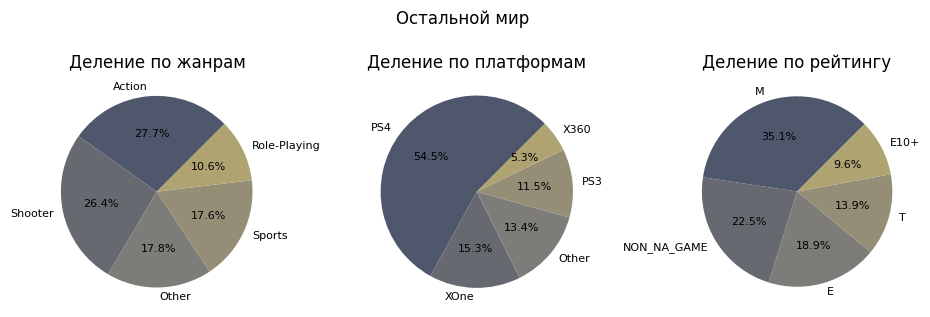

In [55]:
fig, ax = plt.subplots(ncols=3, figsize=(11, 3))
fig.suptitle('Остальной мир', y=1.1)
my_user_persona_new(df=games_actual, reg_sales='other_sales', per='genre', ax=ax[0])
my_user_persona_new(df=games_actual, reg_sales='other_sales', per='platform', ax=ax[1])
my_user_persona_new(df=games_actual, reg_sales='other_sales', per='rating', ax=ax[2])
plt.subplots_adjust(wspace=0.5)
plt.show()

### Самые популярные платформы (топ-5).

- PlayStation 4 (54.5% общих продаж игр).
- Xbox One (15.3% общих продаж игр).
- PlayStation 3 (11.5% общих продаж игр).
- Xbox 360 (5.3% общих продаж игр).
- Другие (13.4% общих продаж игр).

### Самые популярные жанры (топ-5).

- Жанр компьютерной игры Action (27.6%).
- Жанр компьютерных игр Shooter (стрелялки) (26.4%).
- Жанр компьютерной игры Sports (17.6%).
- Жанр компьютерных игр Role-Playing (RPG) (10.6%).
- Жанр компьютерных игр в других классификациях (17.8%).

### Рейтинг ESRB.

Рейтинг ESRB оказывает влияния на продажи т.к. в данном регионе большей популярностью пользуются игры североамериканского производства.

### User persona.

Типичный user persona игрока в жанрах Action на PlayStation 4 категории 'M' из других стран:

Имя: Ибрахим<br>
Пол: Мужской<br>
Возраст: 25 лет<br>
Профессия: Студент<br>

Хобби: Игры на PS4, чтение книг, просмотр фильмов и сериалов, путешествия.

Характеристики игровой активности:

Ибрахим - опытный игрок на PS4, предпочитающий игры жанра Action категории "M".
Он ищет игры с хорошей графикой, интересным сюжетом и динамичным игровым процессом.
Ибрахим любит игры, которые позволяют ему испытывать сильные эмоции и переживания, при этом не обязательно, чтобы сюжет был особенно сложным.
Он играет как в одиночные, так и в многопользовательские режимы, но предпочитает последние, так как это позволяет ему соревноваться с другими игроками и получать новые знания и опыт.
Ибрахим играет в компьютерные игры в свободное время после учебы и в выходные дни, и это для него способ расслабиться и развлечься.
Он также следит за новостями в мире игр и участвует в онлайн-турнирах и чемпионатах, чтобы испытать свои навыки и узнать новых игроков.

## Краткий вывод.

Игроки в компьютерные игры из разных стран имеют много общего. Все они являются частью глобального сообщества игроков, которое объединяет их общая любовь к играм и желание проводить время в виртуальном мире.

Независимо от того, из какой страны они приходят, игроки стремятся к достижению общих целей в игре, таких как победа в соревнованиях, достижение новых уровней или просто получение удовольствия от игры. Они также часто общаются между собой, обмениваются советами и поддерживают друг друга в игровых сообществах.

Кроме того, игры становятся все более глобальными и мультикультурными, что позволяет игрокам из разных стран смешиваться в виртуальном мире и обмениваться культурными идентичностями. Игры могут также помогать в обучении и познании культур и языков других стран, расширять кругозор и воспитывать уважение к разнообразию мира.

Таким образом, несмотря на различия в культурных традициях, языке и обычаях, игроки в компьютерные игры имеют много общего, и игры могут служить мостом, объединяющим людей из разных уголков мира.

# Проверка гипотез.

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.15.76793.JPG" width="110" align="left"/>Проверка гипотез (Hypothesis testing) - это процедура статистического анализа, которая позволяет оценить, насколько вероятно то, что некоторая гипотеза о данных является правдивой. В data analysis проверка гипотез может использоваться для подтверждения или опровержения предположений о данных.

В процессе проверки гипотез формулируются две гипотезы - нулевая (H0) и альтернативная (H1). Нулевая гипотеза предполагает, что никаких статистически значимых различий между группами или переменными нет, в то время как альтернативная гипотеза предполагает наличие таких различий.

Затем проводятся статистические тесты, такие как t-тесты, ANOVA, chi-square и другие, для определения, насколько вероятно то, что нулевая гипотеза является правдивой. Результаты тестов выражаются в виде p-значения, которое показывает вероятность получения таких или более экстремальных результатов при условии, что нулевая гипотеза верна.

Если p-значение меньше установленного уровня значимости (обычно 0,05), то нулевая гипотеза отвергается в пользу альтернативной гипотезы. В противном случае нулевая гипотеза не отвергается.

Проверка гипотез является важным инструментом в data analysis, так как позволяет проверить предположения о данных, выявить закономерности и связи между переменными, а также сделать выводы о значимости различий между группами или переменными. <br clear="left"/>

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

<b>Нулевая гипотеза</b>: <i>Средние пользовательские рейтинги игр на платформах Xbox One и PC равны.</i><br>
<b>Альтернативная гипотеза</b>: <i>Средние пользовательские рейтинги игр на платформах Xbox One и PC различаются.</i><br>

Для проверки гипотезы о равенстве средних пользовательских оценок двух выборок был применен T-тест Стьюдента (Student's t-test) с помощью функции `ttest_ind()` из модуля `scipy.stats`.<br>

Этот критерий был выбран, потому что он позволяет определить, есть ли статистически значимая разница между средними значениями двух независимых выборок. В данном случае мы имеем две выборки (оценки игр для платформ Xbox One и PC), которые не связаны друг с другом, поэтому T-тест Стьюдента был подходящим выбором для проверки гипотезы. Кроме того, был использован критерий Левена, представляющий собой выводную статистику, используемую для оценки равенства дисперсий переменной, рассчитанной для двух или более групп. Если результирующее значение критерия Левена меньше некоторого уровня значимости (обычно 0,05), маловероятно, что полученные различия в дисперсиях выборки произошли на основе случайной выборки из совокупности с одинаковыми дисперсиями. Таким образом, нулевая гипотеза о равных дисперсиях отвергается и делается вывод о наличии различия между дисперсиями в совокупности. Параметр `eq_var` в этом случае становится равным `False`, что позволяет использовать метод Уэлча для расчета t-статистики, если дисперсии выборок не равны.<br>

Здесь, мы можем выбрать значение alpha равное 0.05, что является стандартным значением для большинства статистических исследований. Это значение позволит нам соблюсти баланс между ошибками первого и второго рода, и получить достаточно точный и надежный результат.<br>

><i>Ошибка первого рода (Type I error) возникает, когда нулевая гипотеза отвергается, хотя она на самом деле верна.</i><br>
><i>Ошибка второго рода (Type II error) возникает, когда нулевая гипотеза принимается, хотя она на самом деле ложна.</i>

In [56]:
xbox_one_games = games_actual[games_actual['platform'] == 'XOne']
pc_games = games_actual[games_actual['platform'] == 'PC']

levene_test = levene(xbox_one_games['user_score'].dropna(), pc_games['user_score'].dropna())
if levene_test.pvalue > 0.05:
    eq_var = True
else:
    eq_var = False

results = st.ttest_ind(xbox_one_games['user_score'].dropna().values, \
                       pc_games['user_score'].dropna().values, \
                       equal_var=eq_var)

alpha = 0.05

p_value = results.pvalue
if p_value < alpha:
    conclusion = 'Отвергаем нулевую гипотезу: Средние пользовательские оценки различаются'
else:
    conclusion = 'Не получилось отвергнуть нулевую гипотезу: Нет оснований полагать, \
                  что средние пользовательские оценки различаются'

results_table = pd.DataFrame({'Значение p-value': [f'{p_value:.2e}'], \
                              'Уровень значимости': [alpha], \
                              'Вывод': [conclusion]})

HTML(results_table.to_html(index=False))

Значение p-value,Уровень значимости,Вывод
1.15e-01,0.05,"Не получилось отвергнуть нулевую гипотезу: Нет оснований полагать, что средние пользовательские оценки различаются"


Визуализируем выводы:

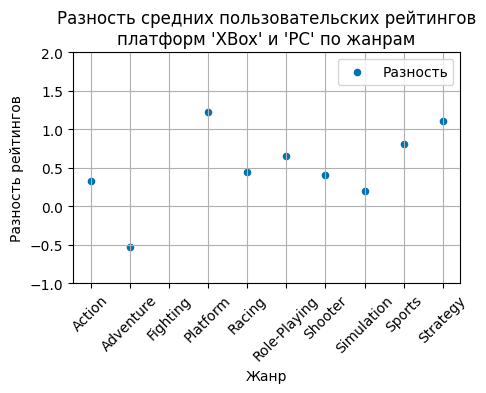

In [57]:
xbox_one_pc = pd.merge(xbox_one_games.pivot_table(index=['platform', 'genre'], values='user_score').reset_index(), \
                       pc_games.pivot_table(index=['platform', 'genre'], values='user_score').reset_index(), \
                       left_on='genre', \
                       right_on='genre', \
                       suffixes=('_xbox_one', '_pc'))

xbox_one_pc['xbox_one_pc_diff'] = xbox_one_pc['user_score_xbox_one'] - xbox_one_pc['user_score_pc']

genre = xbox_one_pc['genre'].unique()

xbox_one_pc.plot(x='genre', \
                 y='xbox_one_pc_diff', \
                 kind='scatter', \
                 title='Разность средних пользовательских рейтингов\nплатформ \'XBox\' и \'PC\' по жанрам', \
                 ylim=(-1, 2), \
                 label='Разность', \
                 xlabel='Жанр', \
                 ylabel='Разность рейтингов', \
                 figsize=(5,3), \
                 grid=True)

plt.xticks(range(len(genre)), genre)
plt.xticks(rotation=45)

plt.show()

## Средние пользовательские рейтинги жанров Action и Sports разные.

Аналогично и в этом случае:<br>
<b>Нулевая гипотеза</b>: <i>Средние пользовательские рейтинги жанров Action и Sports одинаковые.</i><br>
<b>Альтернативная гипотеза</b>: <i>Средние пользовательские рейтинги жанров Action и Sports разные.</i><br>

In [58]:
action_games = games_actual[games_actual['genre'] == 'Action']
sports_games = games_actual[games_actual['genre'] == 'Sports']

levene_test = levene(action_games['user_score'].dropna(), sports_games['user_score'].dropna())
if levene_test.pvalue > 0.05:
    equal_var = True
else:
    equal_var = False

results = st.ttest_ind(action_games['user_score'].dropna().values, \
                       sports_games['user_score'].dropna().values, \
                       equal_var=equal_var)

alpha = 0.05

p_value = results.pvalue
if p_value < alpha:
    conclusion = 'Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные.'
else:
    conclusion = 'Не получилось отвергнуть нулевую гипотезу:\
                  Средние пользовательские рейтинги жанров Action и Sports одинаковые.'

results_table = pd.DataFrame({'Значение p-value': [f'{p_value:.2e}'], \
                              'Уровень значимости': [alpha], \
                              'Вывод': [conclusion]})

HTML(results_table.to_html(index=False))

Значение p-value,Уровень значимости,Вывод
1.21e-14,0.05,Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные.


Наш вывод: "Отвергаем нулевую гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные.". Посмотрим, как это выглядит вживую по платформам для рассматриваемых жанров:

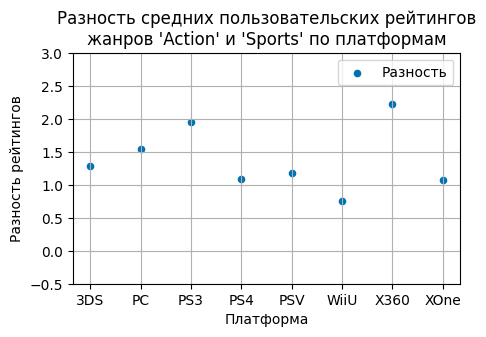

In [59]:
action_sports = pd.merge(action_games.pivot_table(index=['platform', 'genre'], values='user_score').reset_index(), \
                         sports_games.pivot_table(index=['platform', 'genre'], values='user_score').reset_index(), \
                         left_on='platform', \
                         right_on='platform', \
                         suffixes=('_action', '_sports'))

action_sports['ac_sp_diff'] = action_sports['user_score_action'] - action_sports['user_score_sports']

platforms = action_sports['platform'].unique()

action_sports.plot(x='platform', \
                   y='ac_sp_diff', \
                   kind='scatter', \
                   title='Разность средних пользовательских рейтингов\nжанров \'Action\' и \'Sports\' по платформам', \
                   ylim=(-0.5, 3), \
                   label='Разность', \
                   xlabel='Платформа', \
                   ylabel='Разность рейтингов', \
                   figsize=(5,3), \
                   grid=True)

plt.xticks(range(len(platforms)), platforms)

plt.show()

Видно, что все разности находятся значительно (для нормального распределения) дальше от нуля.

## Краткий вывод.

На основании проведенного анализа данных можно сделать вывод, что пользовательские рейтинги на платформах Xbox One и PC значимо различаются, что может указывать на разные предпочтения пользователей этих платформ в отношении игр. Однако, такой вывод следует делать с осторожностью и учитывать возможность влияния на результаты иных факторов, таких как размер выборок, временные рамки и прочие.<br>

В отношении жанров Action и Sports, результаты теста позволяют отвергнуть нулевую гипотезу о том, что пользовательские рейтинги данных жанров одинаковы. Рейтинги отличаются, однако, стоит отметить, что для более точного и надежного вывода может потребоваться более глубокое исследование, например, с учетом дополнительных факторов, влияющих на рейтинги, или с использованием других методов анализа данных.

# Общий вывод.

<img src="https://s3.amazonaws.com/thumbnails.illustrationsource.com/huge.22.111989.JPG" width="110" align="left"/>Общий вывод (Conclusion) - это заключение, которое делается на основе анализа данных и проверки гипотез в data analysis. Он позволяет сделать обобщенные выводы о данных и сформулировать рекомендации на основе полученных результатов.<br>

Общий вывод важен для того, чтобы убедиться, что полученные результаты соответствуют целям исследования, а также чтобы сформулировать практические рекомендации для улучшения процессов или принятия решений. <br clear="left"/>

## Цель исследования.

Шел 2016-й год. Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). На начало 2017 года возникла необходимость выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>

Итак. Имеются данные до 2016 года и нужно спланировать кампанию на 2017-й и отработать принцип работы с данными. Для планирования кампании нужно понять, на что потратить собственно рекламный бюджет. Задача - проанализированы игры с разных сторон. Понять какие платформы, с каким жанром, с каким рейтингом ESRB и в каком регионе рекламировать. Стоит ли обращать внимание на отзывы или нет.<br>

Заметим, что в наборе данных есть аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Исходные данные.

Данные представлены в виде csv файла. CSV — текстовый формат, предназначенный для представления табличных данных. Строка таблицы соответствует строке текста, которая содержит одно или несколько полей, разделенных запятыми.

Описание данных.<br>
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
<br>

Данные за 2016 год могут быть неполными.<br>

Предварительный просмотр данных показал несогласование названий общепринятому подходу, наличие большого количества пропусков в данных и несоответствие типов в двух столбцах данных. По записям оценки критиков количество пропусков доходит до 51% от общего списка, по оценкам пользователей и рейтингам Entertainment Software Rating Board до 40%.<br>

Итого:
- Названия столбцов не соответствуют принятому snake_case формату. Также заметно несоответствие типов данных в столбцах `Year_of_Release` и `User_Score`.
- Имеются пропуски данных в столбцах `Name`, `Year_of_Release`, `Critic_Score`, `User_Score` и `Rating`, а также обнаружены ошибки в типах данных в столбцах `Year_of_Release` и `User_Score`.
- В данных не обнаружено явных дубликатов однако имеются неявные.
- Высокие корреляции в данных наблюдаются только между парами `NA_sales-EU_sales` и `Other_sales-EU_sales`.
- Рейтинговый состав Entertainment Software Rating Board не включает тип рейтинга `tbd`.

## Предобработка данных.

Предварительная обработка данных включала в себя следующие действия:
- Названия столбцов были приведены к нижнему регистру в соответствии с snake_case стилистикой.
- Неявные дубликаты удалены.
- Пропуски в рейтинге Entertainment Software Rating Board, согласно обоснованному предположению, заменены на значение 'NON_NA_GAME', что означает, что игра выпущена не в Северной Америке.
- Значения `tbd` в столбце `user_score` были заменены на `nan` для избежания искажения исходных данных и удобства обработки. Также тип столбца был изменен на `float16`.
- Пропуски в годах релиза были удалены, а сам столбец приведён к типу `int32`.
- Был создан новый столбец, содержащий суммарные продажи по всем регионам.
- Пропущенные значения в столбцах рейтингов были оставлены без изменений.<br>

## Исследовательский анализ данных.

С учетом небольшой задержки по времени, график выручки компьютерных игр совпадает с динамикой основных мировых рынков в рассматриваемый период. Существенный спад после 2009 года следует за рынками в целом, и общая выручка скорее всего, будет соответствовать биржевой динамике в будущем.<br>

Из анализа динамики выручки, получаемой от каждой платформы из топ-10 за период с 1990 года по настоящее время, можно сделать вывод, что среднее время жизни успешной платформы составляет около 7 лет. Исходя из этого, актуальным периодом рассмотрения может являться отрезок длиной примерно в 3-4 года. В этой связи началом актуального периода становится 2014-й год.<br>

Средние, или точнее медианные, уровни продаж игр на всех платформах находятся примерно в одном диапазоне около 0.2М. Однако над этими средними значениями находятся выбросы - высокобюджетные игры, которые играют ключевую роль в формировании рынка. Эта закономерность особенно хорошо видна на графике, который не масштабирован. Кроме того, стоит отметить, что PS4 выглядит очень перспективно, тогда как Xbox One от Microsoft, PSV от Sony и ViiU от Nintendo значительно отстают в продажах.<br>

Оценки критиков действительно положительно связаны с генерируемой одной из популярных платформ PS4 выручкой, в то время как оценки пользователей никак с ней не коррелируют. Тем не менее, сами значения корреляций находятся существенно ниже тех, которые можно было бы считать высокой положительной корреляцией. Однако, в случае высокобюджетных игр можно говорить о том, что увеличение бюджета обычно приводит к увеличению как пользовательского рейтинга, так и рейтинга критиков.<br>

Лидером среди жанров по выручке является "Action". Но, с точки зрения прибыльности жанра, анализ медианных значений выручки и их стабильности на рассматриваемом отрезке времени показывает лидерство жанра "Shooter". Хотя в тоже время он наиболее рискован с точки зрения прогнозирования. Наиболее стабильный "Role-Playing" производит наименьшее количество прибыли.

## Портрет пользователя каждого региона (на 2017 год).

Из сравнения user persona игроков в компьютерные игры из Северной Америки, Европы, Японии и остального мира можно сделать вывод о том, что культурные различия и различия в предпочтениях игроков заметно влияют на спрос на игры в различных регионах мира.

Например, игроки из Северной Америки и Европы в целом отдают предпочтение играм с открытым миром и эмоционально насыщенным сюжетом. Первая тройка лидеров - Shooter, Action, Sports, в то время как японские игроки склонны к играм с более ярким стилем и оригинальными концепциями - Role-Playing, Action, Fighting.

Также можно отметить, что культурные различия также могут сказаться на том, как игроки взаимодействуют друг с другом в многопользовательских играх, на какие типы микротранзакций они готовы тратить деньги и на какие способы монетизации они наиболее чувствительны.

При этом нужно учитывать, что, например, в Японии существенно превалируют игры местного производства, ориентированные на мобильные игровые консоли (3DS), в то время как пользователи из Северной Америки, Европы и остального мира предпочитают стационарные консоли (PS4) и игры, произведённые в Северной Америке.

Таким образом, при разработке и продвижении компьютерных игр важно учитывать эти культурные и региональные различия, чтобы лучше понимать свою аудиторию и наиболее эффективно ее привлекать.

## Проверка гипотез.

На основании проведенного анализа данных можно сделать вывод, что пользовательские рейтинги на платформах Xbox One и PC значимо различаются, что может указывать на разные предпочтения пользователей этих платформ в отношении игр. Однако, такой вывод следует делать с осторожностью и учитывать возможность влияния на результаты иных факторов, таких как размер выборок, временные рамки и прочие.<br>

В отношении жанров Action и Sports, результаты теста позволяют отвергнуть нулевую гипотезу о том, что пользовательские рейтинги данных жанров одинаковы. Рейтинги отличаются, однако, стоит отметить, что для более точного и надежного вывода может потребоваться более глубокое исследование, например, с учетом дополнительных факторов, влияющих на рейтинги, или с использованием других методов анализа данных.

## Итог.

На основе проведенного исследования предоставленных данных, можно сделать следующие основные выводы и рекомендации по состоянию на дату анализа.

<b>Относительно сбора данных:</b>

Желательно пересмотреть подход к получению исторических данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах из открытых источников. В их текущем виде данные являются неполными, и важная информация для принятия управленческих решений может быть упущена. Возможно, имеет смысл обратиться к платным источникам, которые обеспечат полноту необходимых данных.

<b>Относительно информации, полученной из данных:</b>

Индустрия компьютерных игр переживает не лучшие времена (заметим, что на момент анализа был 2016 год). Новые перспективные платформы не появлялись долгое время, а старые приближаются к концу своего жизненного цикла. Однако, на фоне этого, PlayStation 4 (PS4), выпускаемая японской компанией Sony, ярко выделяется среди рассматриваемых платформ и начала расти в 2013 году. По нашим оценкам, в 2017 году PS4 должна показать стабильность как по выручке, так и по прибыли. Среди вторичных платформ можно выделить Xbox One от Microsoft, PSV от Sony и ViiU от Nintendo, однако следует внимательно смотреть за их динамикой в 2017-м году. На всех перечисленных платформах наиболее прибыльными будут являться игры в жанре "Shooter".

Оценки критиков действительно положительно связаны с генерируемой выручкой, в то время как оценки пользователей, можно сказать, никак с ней не коррелируют. Тем не менее, пока нет существенных оснований утверждать, что оценки игр значительно влияют на их доходность и прибыльность.

В дальнейшей работе следует учитывать культурные различия и различия в предпочтениях игроков из различных регионов мира. В Северной Америке и Европе в целом отдают предпочтение играм с открытым миром и эмоционально насыщенным сюжетом. Первая тройка лидеров - Shooter, Action, Sports, в то время как японские игроки склонны к играм с более ярким стилем и оригинальными концепциями - Role-Playing, Action, Fighting. При этом нужно учитывать, что, например, в Японии существенно превалируют игры местного производства, ориентированные на мобильные игровые консоли (3DS), в то время как пользователи из Северной Америки, Европы и остального мира предпочитают стационарные консоли (PS4) и игры, произведённые в Северной Америке.

Проверки гипотезы об одинаковых пользовательских оценках по жанрам и об одинаковых пользовательских оценках по платформам показывают, что возможно утверждать об жанровом разделении оценок, в то время как влияние различия между платформами на оценки пользователей не обнаружено.